# Object detection model - KITTI

> Object Detection Model


- skip_showdoc: true
- skip_exec: true

## KITTI

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torchvision
from torchvision import models, datasets, tv_tensors, transforms
from torchvision.transforms import v2, ToPILImage
from torchvision.datasets import Kitti, VisionDataset

import torch.utils.data
from torch.utils.data import DataLoader


In [ ]:
from tqdm import tqdm
import cv2
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
class Kitti_v2(Kitti):
    def __init__(self, *args, **kwargs):
        super(Kitti_v2, self).__init__(*args, **kwargs)

In [ ]:
torch.manual_seed(0)

<torch._C.Generator>

In [ ]:
path = './Data'


# desired_size = (round(375/2), round(1242))
desired_size = (250, 500)


In [ ]:
transform2 = v2.Compose(
    [
        v2.ToImage(),
        # v2.Resize(size = desired_size),  # Resize image
        
        v2.RandomPhotometricDistort(p=0.2),
        v2.RandomZoomOut(fill={tv_tensors.Image: (123, 117, 104), "others": 0}),
        # v2.RandomIoUCrop(),
        v2.RandomHorizontalFlip(p=0.4),
        # v2.SanitizeBoundingBoxes(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)
# Load KITTI train dataset
train_dataset = Kitti_v2(root=path, train='true', download=True, transforms=transform2)

# Load KITTI test dataset
test_dataset = Kitti_v2(root=path, train='false', download=True, transforms=transform2)

In [ ]:
sample = train_dataset[1000]
img, target = sample
print(f"{type(img) = }\n{type(target) = }")

type(img) = <class 'torchvision.tv_tensors._image.Image'>
type(target) = <class 'list'>


In [ ]:
train_dataset2 = datasets.wrap_dataset_for_transforms_v2(train_dataset, target_keys=("boxes", "labels"))

test_dataset2 = datasets.wrap_dataset_for_transforms_v2(test_dataset, target_keys=("boxes", "labels"))

In [ ]:
sample = train_dataset2[1000]
img, target = sample
print(f"{type(img) = }\n{type(target) = }\n{target.keys() = }")
print(f"{type(target['boxes']) = }\n{type(target['labels']) = }")

type(img) = <class 'torchvision.tv_tensors._image.Image'>
type(target) = <class 'dict'>
target.keys() = dict_keys(['boxes', 'labels'])
type(target['boxes']) = <class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'>
type(target['labels']) = <class 'torch.Tensor'>


In [ ]:
def cv2_show(image_np, label):
    image_cv2 = cv2.cvtColor((image_np * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    for bbox, item in zip(label['boxes'], label['labels']):
        # Draw the bounding box
        cv2.rectangle(image_cv2, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)
    
        # Display the label
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image_cv2, str(item), (int(bbox[0]), int(bbox[1]) - 10), font, 0.5, (0, 255, 0), 2, cv2.LINE_AA)

    # Convert the image back to RGB format for display with Matplotlib
    image_rgb = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
    
    return image_rgb

def show_image(kitti_dataset):
    # Access an image and its label from the dataset
    image, label = kitti_dataset
    
    # Convert the image tensor to a NumPy array
    image_np = image.numpy().transpose((1, 2, 0))
    image_rgb = cv2_show(image_np, label)
    # Display the image using Matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

# Define a function to display images
def show_images(images, labels, **kwargs):
    nrows = int(math.sqrt(len(images)))
    ncols = int(np.floor(len(images)/nrows))
        
    fig, axes = plt.subplots(nrows, ncols, **kwargs)
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.01, hspace=0.01)

    # Display the image using Matplotlib
    for ax, image, label in zip(axes.flat, images, labels):
        # Convert image to numpy array and adjust pixel values
        image_np = image.numpy().transpose((1, 2, 0))
        image_rgb = cv2_show(image_np, label)
        
        # Display image
        ax.imshow(image_rgb)
        ax.axis('off')

    for ax in axes.flat[len(images):]:
        ax.axis('off')
    plt.show()

In [ ]:
image,_ = train_dataset2[18]
image.shape

torch.Size([3, 370, 1224])

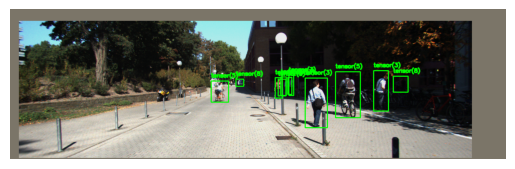

In [ ]:
show_image(train_dataset2[18])

In [ ]:
batch_size = 2

train_loader = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True, collate_fn=lambda batch: tuple(zip(*batch)), num_workers = 8)

# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False, collate_fn=lambda batch: tuple(zip(*batch)), num_workers = 8)

#### Iter

In [ ]:
# Get a batch of images and labels from the data loader
examples = iter(train_loader)
images, labels = next(examples)


In [ ]:
images[1].shape

torch.Size([3, 1082, 3585])

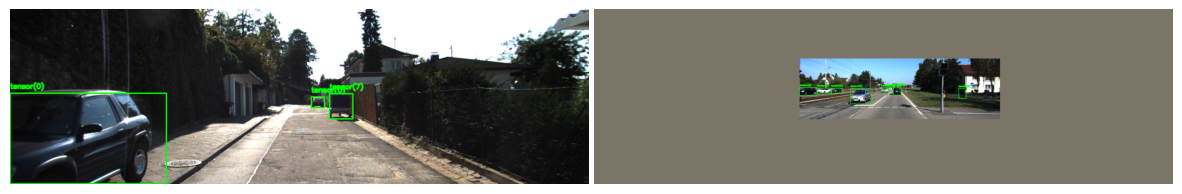

In [ ]:
show_images(images, labels, figsize=(15, 5))

### Model

In [ ]:
from torchvision.io.image import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

In [ ]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# Step 1: Initialize model with the best available weights
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights,
                                   box_score_thresh=0.9).train() 


model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [ ]:
model.to(device)

In [ ]:
# Define an optimizer (you can use any optimizer from torch.optim)
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate,
                            momentum=0.9)
# Define optimizer and learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)


In [ ]:
len(train_loader)

3741

In [ ]:
# Training loop
for epoch in range(5):
    model.train()
    total_loss = 0.0
    
    for imgs, targets in tqdm(train_loader):
        # Move input data to GPU
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimization
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()
    
    # Update learning rate scheduler
    lr_scheduler.step()
    
    # Print average loss for the epoch
    print(f"Average Loss: {total_loss / len(train_loader):.4f}")

100%|███████████████████████████████████████████████████████████████████████████████| 3741/3741 [34:34<00:00,  1.80it/s]


Average Loss: 0.4006


 34%|███████████████████████████▏                                                   | 1287/3741 [12:08<23:09,  1.77it/s]


KeyboardInterrupt: 